This notebook aims at testing supervised learning applied to bot detection on twitter

# Initialization

Imports.\
PySpark is used to manipulate dataframes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc, classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize, StandardScaler

from collections import Counter

import math


PySpark session and link to access it.\
Do NOT forget to forward **port 4040** if using SSH.\
http://localhost:4040

In [ ]:
dbname = ''
user = ''
password = ';'
host = ''
port = 

connection_string = f"postgresql+psycopg2://{user}:{password}@/{dbname}"
engine = create_engine(connection_string)

# All datasets

Load data

In [3]:
users_c15 = pd.read_sql_query('SELECT user_id, label, screen_name FROM cresci_2015_users', engine)
users_c17 = pd.read_sql_query('SELECT user_id, label, screen_name FROM cresci_2017_users', engine)
users_tb20 = pd.read_sql_query('SELECT id, username FROM tb20_users', engine)
users_tb22 = pd.read_sql_query('SELECT id, username FROM tb22_user', engine)

users_tb20.rename(columns={'username': 'screen_name'}, inplace=True)
users_tb22.rename(columns={'username': 'screen_name'}, inplace=True)

labels_tb20 = pd.read_sql_query('SELECT id, label FROM tb20_label', engine)
labels_tb22 = pd.read_sql_query('SELECT id, label FROM tb22_label', engine)

users_tb20 = pd.merge(users_tb20, labels_tb20, left_on='id', right_on='id')
users_tb22 = pd.merge(users_tb22, labels_tb22, left_on='id', right_on='id')

users_c15['label_num'] = users_c15['label'].apply(lambda x: 0 if x == 'human' else 1)
users_c17['label_num'] = users_c17['label'].apply(lambda x: 0 if x == 'human' else 1)
users_tb20['label_num'] = users_tb20['label'].apply(lambda x: 0 if x == 'human' else 1)
users_tb22['label_num'] = users_tb22['label'].apply(lambda x: 0 if x == 'human' else 1)

In [4]:
users_tb20.rename(columns={'id': 'user_id'}, inplace=True)
users_tb22.rename(columns={'id': 'user_id'}, inplace=True)

In [5]:
df_list = [users_c15, users_c17, users_tb20, users_tb22]
df_names = ['cresci2015', 'cresci2017', 'tb20', 'tb22']

Feature engineering

In [6]:
# create a string containing all the characters a-z A-Z 0-9 and _ to make sure all datasets have the same amount of bigrams in their feature space
all_chars = ''.join([chr(i) for i in range(48, 58)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)] + ['_'])

all_bigrams = ""
for c1 in all_chars:
    for c2 in all_chars:
        all_bigrams += c1 + c2

In [7]:
def bigram(name):
    bigram = []
    for i in range(len(name)-1):
        bigram.append(name[i:i+2])
    return bigram

def upper_count(name):
    count = sum(1 for c in name if c.isupper())
    return count / len(name)

def lower_count(name):
    count = sum(1 for c in name if c.islower())
    return count / len(name)

def shannon_entropy(name):
    p, lns = Counter(name), float(len(name))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

def tfidf(noms):
    noms = [all_bigrams] + noms
    list_ngrams = [bigram(nom) for nom in noms]
    strings_ngrams = []
    for ngram in list_ngrams:
       strings_ngrams.append(' '.join(ngram)) 

    vectorizer = CountVectorizer() 
    tfidftrans = TfidfTransformer() 

    word_freq = vectorizer.fit_transform(strings_ngrams)
    tfidf = tfidftrans.fit_transform(word_freq)
    tfidf_list = tfidf.toarray().tolist()
    # remove the first element which is the tfidf of all_bigrams
    tfidf_list = tfidf_list[1:]
    
    return tfidf_list



In [8]:
# for each dataset, create the list of features.

for j in range(len(df_list)):
    df = df_list[j]
    df_name = df_names[j]
    
    screen_names = df['screen_name'].tolist()
    features = tfidf(screen_names)

    for i in range(len(screen_names)):
        features[i].append(float(shannon_entropy(screen_names[i])))
        features[i].append(float(upper_count(screen_names[i])))
        features[i].append(float(lower_count(screen_names[i])))

    df = pd.concat([df, pd.DataFrame(features)], axis=1)
    df_list[j] = df

In [11]:
df_list[3].head()

,user_id,screen_name,label,label_num,0,1,2,3,4,5,...,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
0,u1217628182611927040,boazbaraktcs,human,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.022055,0.000000,1.000000
1,u2664730894,wale_io,human,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.807355,0.000000,0.857143
2,u1266703520205549568,b_panagiota,human,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.027169,0.000000,0.909091
3,u1089159225148882949,jachodges_md,human,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.418296,0.000000,0.916667
4,u36741729,Matthew_Brody,bot,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.546594,0.153846,0.769231


# Model

In this cell, all the functions are defined

In [14]:
# Object used to store the results of the prediction
class Report:
    def __init__(self, accuracy, precision, recall, specificity, f1, mcc, roc_auc):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.specificity = specificity
        self.f1 = f1
        self.mcc = mcc
        self.roc_auc = roc_auc

    def __str__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"

    def __repr__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"

# Function to split the dataset into training and testing sets. If notest is set to True, the testing set is empty (for cross-validation)
def split(df, prop_bot, balancing=True, notest=False, testprop=0.2):
    df_bot = df[df['label_num'] == 1]
    df_human = df[df['label_num'] == 0]

    if balancing:
        nb_bots = len(df_bot)
        nb_humans = len(df_human)

        sample_nb_humans = min(nb_bots / prop_bot, nb_humans)
        sample_nb_bots = sample_nb_humans * prop_bot
        
        if sample_nb_bots < 5:
            sample_nb_bots = 5
        if sample_nb_humans < 5:
            sample_nb_humans = 5
        
        df_bot = df_bot.sample(int(sample_nb_bots))
        df_human = df_human.sample(int(sample_nb_humans))

    df = pd.concat([df_bot, df_human])

    X = df.drop(['user_id', 'label', 'screen_name', 'label_num'], axis=1)
    X = normalize(X, axis=0)
    X = pd.DataFrame(X)

    y = df['label_num']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testprop, stratify=y)

    if notest:
        X_train = X
        y_train = y
        X_test = []
        y_test = []

    return X_train, X_test, y_train, y_test  

# Function to split the dataset into training and testing sets
def split_test(df, prop_bot):
    df_bot = df[df['label_num'] == 1]
    df_human = df[df['label_num'] == 0]

    nb_bots = len(df_human) * prop_bot
    df_bot = df_bot.sample(int(nb_bots))

# Function to train the model, using grid search if specified
def train(X_train, y_train, using_grid_search=True):
    X_train = normalize(X_train, axis=0)
    if not using_grid_search:
        lr = LogisticRegression(C=1, penalty='l2', solver='liblinear')
        lr.fit(X_train, y_train)
        return lr
    
    lr = LogisticRegression()
    param_grid = {
        'C': [1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0) # CROSS VALIDATION 5 FOLDS 
    grid_search.fit(X_train, y_train)
    # print the best hyperparameters
    print(grid_search.best_params_)
    return grid_search.best_estimator_

# Function to train the model using cross-validation with 5 folds
def train_cv(X, y):
    #X = normalize(X, axis=0)
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    # parameters : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
    model = LogisticRegression(C=10, penalty='l2', solver='liblinear')
    
    reports = []

    for train_index, test_index in cv.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        clf = clone(model)
        clf.fit(X_train_cv, y_train_cv)

        y_pred = clf.predict(X_test_cv)
        y_prob = clf.predict_proba(X_test_cv)[:, 1]

        acc = accuracy_score(y_test_cv, y_pred)
        prec = precision_score(y_test_cv, y_pred)
        rec = recall_score(y_test_cv, y_pred)
        spec = recall_score(y_test_cv, y_pred, pos_label=0)
        f1 = f1_score(y_test_cv, y_pred)
        mcc = matthews_corrcoef(y_test_cv, y_pred)
        roc_auc = roc_auc_score(y_test_cv, y_prob)
        
        # create a report object
        report = Report(acc, prec, rec, spec, f1, mcc, roc_auc)
        reports.append(report)

    return reports

# Function to evaluate the model using various metrics
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1] 

    cm = confusion_matrix(y_test, y_pred)
    tp, fp, fn, tn = cm.ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)

    return Report(accuracy, precision, recall, specificity, f1, mcc, roc_auc)

# Function running a series of tests and returning the results
def run_test(df, prop_bot, repetitions, using_fav_count=True, using_grid_search=False, balancing=True):
    reports = []
    for _ in range(repetitions):
        X_train, X_test, y_train, y_test = split(df, prop_bot, using_fav_count, balancing)
        model = train(X_train, y_train, using_grid_search)
        report = evaluate(model, X_test, y_test)
        reports.append(report)
    return reports

# Function running a series of tests using cross-validation and returning the results
def run_test_cv(df, prop_bot, balancing=True):
    X_train, X_test, y_train, y_test = split(df, prop_bot, balancing, notest=True)
    reports = train_cv(X_train, y_train)
    return reports

# Function running a series of tests on a training set and a different testing set and returning the results
def run_on_other(df_train, df_test, prop_bot, repetitions, using_fav_count=True, using_grid_search=False, balancing=True):
    reports = []
    for _ in range(repetitions):
        X_train, _, y_train, _ = split(df_train, prop_bot, using_fav_count, balancing, notest=True)
        X_test, _, y_test, _ = split(df_test, prop_bot, using_fav_count, balancing, notest=True)
        model = train(X_train, y_train, using_grid_search)
        report = evaluate(model, X_test, y_test)
        reports.append(report)
    return reports

# Function to print the average and standard deviation of each metric
def print_avg_std(reports):
    accuracy = np.mean([r.accuracy for r in reports])
    precision = np.mean([r.precision for r in reports])
    recall = np.mean([r.recall for r in reports])
    specificity = np.mean([r.specificity for r in reports])
    f1 = np.mean([r.f1 for r in reports])
    mcc = np.mean([r.mcc for r in reports])
    roc_auc = np.mean([r.roc_auc for r in reports])

    accuracy_std = np.std([r.accuracy for r in reports])
    precision_std = np.std([r.precision for r in reports])
    recall_std = np.std([r.recall for r in reports])
    specificity_std = np.std([r.specificity for r in reports])
    f1_std = np.std([r.f1 for r in reports])
    mcc_std = np.std([r.mcc for r in reports])
    roc_auc_std = np.std([r.roc_auc for r in reports])

    print("Accuracy:", accuracy, "+-", accuracy_std)
    print("Precision:", precision, "+-", precision_std)
    print("Recall:", recall, "+-", recall_std)
    print("Specificity:", specificity, "+-", specificity_std)
    print("F1:", f1, "+-", f1_std)
    print("MCC:", mcc, "+-", mcc_std)
    print("ROC AUC:", roc_auc, "+-", roc_auc_std)


# TRAINING and TESTING on the same dataset

### Framework

Function calculating all the metrics over 3 series, average and std. 

Places the results in a CSV under the results/beskow/ directory on top of printing them

In [34]:
def run_tests(prop_bot, filename, balancing=True):
    os.makedirs('./results/beskow', exist_ok=True)

    results = []

    for df, name in tqdm(zip(df_list, df_names), total=len(df_list)):
        reports = run_test_cv(df, prop_bot, balancing=balancing)
        accuracy = np.mean([r.accuracy for r in reports])
        precision = np.mean([r.precision for r in reports])
        recall = np.mean([r.recall for r in reports])
        specificity = np.mean([r.specificity for r in reports])
        f1 = np.mean([r.f1 for r in reports])
        mcc = np.mean([r.mcc for r in reports])
        roc_auc = np.mean([r.roc_auc for r in reports])

        accuracy_std = np.std([r.accuracy for r in reports])
        precision_std = np.std([r.precision for r in reports])
        recall_std = np.std([r.recall for r in reports])
        specificity_std = np.std([r.specificity for r in reports])
        f1_std = np.std([r.f1 for r in reports])
        mcc_std = np.std([r.mcc for r in reports])
        roc_auc_std = np.std([r.roc_auc for r in reports])

        results.append([name, accuracy, accuracy_std, precision, precision_std, recall, recall_std, specificity, specificity_std, f1, f1_std, mcc, mcc_std, roc_auc, roc_auc_std])

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results, columns=['dataset', 'accuracy', 'accuracy_std', 'precision', 'precision_std', 'recall', 'recall_std', 'specificity', 'specificity_std', 'f1', 'f1_std', 'mcc', 'mcc_std', 'roc_auc', 'roc_auc_std'])
    results_df.to_csv(f'./results/beskow/{filename}.csv', index=False)
    return results_df
    

### Sample statistics

Since each dataset is sampled so as to obtain the required bot/human ratio, this cell shows the size of each sample, for each dataset and bot/human prop.

In [113]:
def show_dataset_stats():
    prop_bots = [1, 1/4, 1/9, 1/19]
    
    for prop_bot in prop_bots:
        results = []
        for df, name in zip(df_list, df_names):
            df_bot = df[df['label_num'] == 0]
            df_human = df[df['label_num'] == 1]

            nb_bots = len(df_bot)
            nb_humans = len(df_human)

            sample_nb_humans = min(nb_bots / prop_bot, nb_humans)
            sample_nb_bots = sample_nb_humans * prop_bot

            results.append([name, nb_bots, nb_humans, sample_nb_bots, sample_nb_humans])

        print(f"############### prop_bot: {prop_bot}")
        results_df = pd.DataFrame(results, columns=['dataset', 'nb_bots', 'nb_humans', 'sampled_nb_bots', 'sampled_nb_humans'])
        print(results_df)

show_dataset_stats()

############### prop_bot: 1
      dataset  nb_bots  nb_humans  sampled_nb_bots  sampled_nb_humans
0  cresci2017     1952       3349           1952.0             1952.0
1  cresci2015     3474       8263           3474.0             3474.0
2        tb20     5237       6589           5237.0             5237.0
3        tb22   860057     139943         139943.0           139943.0
############### prop_bot: 0.25
      dataset  nb_bots  nb_humans  sampled_nb_bots  sampled_nb_humans
0  cresci2017     1952       3349           837.25               3349
1  cresci2015     3474       8263          2065.75               8263
2        tb20     5237       6589          1647.25               6589
3        tb22   860057     139943         34985.75             139943
############### prop_bot: 0.1111111111111111
      dataset  nb_bots  nb_humans  sampled_nb_bots  sampled_nb_humans
0  cresci2017     1952       3349       372.111111               3349
1  cresci2015     3474       8263       918.111111      

### 50/50

In [35]:
balanced = run_tests(1, '50', True)
print(balanced)

100%|██████████| 4/4 [00:36<00:00,  9.15s/it]

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.775357      0.010014   0.787977       0.010725  0.753585   
1  cresci2015  0.688255      0.003311   0.675831       0.005850  0.723950   
2        tb20  0.545256      0.012091   0.546864       0.011950  0.526068   
3        tb22  0.567320      0.001566   0.590661       0.002528  0.438650   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.017352     0.797141         0.012437  0.770288  0.011365  0.551381   
1    0.011364     0.652557         0.013935  0.698973  0.003646  0.377582   
2    0.021788     0.564447         0.008346  0.536191  0.016848  0.090583   
3    0.002292     0.695991         0.003768  0.503424  0.001638  0.139338   

    mcc_std   roc_auc  roc_auc_std  
0  0.019944  0.854932     0.011940  
1  0.006456  0.748380     0.008793  
2  0.024135  0.558948     0.006537  
3  0.003358  0.590502     0.001515  


### 20/80

In [36]:
unbalanced20 = run_tests(1/4, '20', True)
print(unbalanced20)

100%|██████████| 4/4 [01:05<00:00, 16.38s/it]

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.832787      0.012404   0.690627       0.054506  0.292931   
1  cresci2015  0.800554      0.005922   0.505912       0.060760  0.111787   
2        tb20  0.790407      0.003865   0.280106       0.062838  0.029031   
3        tb22  0.800004      0.000022   0.452381       0.322968  0.000086   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.059594     0.967732         0.006153  0.409269  0.066433  0.372929   
1    0.015106     0.972654         0.004550  0.182943  0.023838  0.164310   
2    0.003902     0.980714         0.003788  0.052554  0.007471  0.028200   
3    0.000074     0.999984         0.000012  0.000171  0.000147  0.004271   

    mcc_std   roc_auc  roc_auc_std  
0  0.062710  0.820582     0.029384  
1  0.032999  0.724627     0.024288  
2  0.021799  0.550620     0.012526  
3  0.004835  0.592556     0.002386  


### 10/90

In [37]:
unbalanced10 = run_tests(1/9, '10', True)
print(unbalanced10)

 75%|███████▌  | 3/4 [00:02<00:00,  1.29it/s]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-pac

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.904520      0.003754   0.707619       0.177399  0.083298   
1  cresci2015  0.898705      0.002374   0.133333       0.266667  0.010390   
2        tb20  0.898419      0.000658   0.106667       0.137275  0.003434   
3        tb22  0.900001      0.000002   0.000000       0.000000  0.000000   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.018411     0.995386         0.003769  0.147512  0.030738  0.217154   
1    0.020779     0.997409         0.001077  0.019277  0.038554  0.021118   
2    0.004205     0.997708         0.000974  0.006639  0.008131  0.004172   
3    0.000000     1.000000         0.000000  0.000000  0.000000  0.000000   

    mcc_std   roc_auc  roc_auc_std  
0  0.048162  0.789722     0.036321  
1  0.073238  0.681381     0.016465  
2  0.022439  0.533106     0.026659  
3  0.000000  0.591547     0.002382  


### 5/95

In [38]:
unbalanced5 = run_tests(1/19, '5', True)
print(unbalanced5)

  0%|          | 0/4 [00:00<?, ?it/s]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|██▌       | 1/4 [00:00<00:01,  1.81it/s]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/pe

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.948880      0.000050        0.1            0.2  0.009524   
1  cresci2015  0.950219      0.000654        0.0            0.0  0.000000   
2        tb20  0.949746      0.000441        0.0            0.0  0.000000   
3        tb22  0.950000      0.000002        0.0            0.0  0.000000   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.019048     0.997951         0.001024  0.017391  0.034783  0.021805   
1    0.000000     1.000000         0.000000  0.000000  0.000000  0.000000   
2    0.000000     0.999618         0.000468  0.000000  0.000000 -0.002762   
3    0.000000     1.000000         0.000000  0.000000  0.000000  0.000000   

    mcc_std   roc_auc  roc_auc_std  
0  0.060534  0.671460     0.032423  
1  0.000000  0.644891     0.030986  
2  0.003382  0.516019     0.036571  
3  0.000000  0.587138     0.001730  


### 1/99

In [39]:
unbalanced1 = run_tests(1/99, '1', True)
print(unbalanced1)

  0%|          | 0/4 [00:00<?, ?it/s]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sk

      dataset  accuracy  accuracy_std  precision  precision_std  recall  \
0  cresci2017  0.990360      0.001013        0.0            0.0     0.0   
1  cresci2015  0.990026      0.000006        0.0            0.0     0.0   
2        tb20  0.990168      0.000462        0.0            0.0     0.0   
3        tb22  0.990001      0.000003        0.0            0.0     0.0   

   recall_std  specificity  specificity_std   f1  f1_std  mcc  mcc_std  \
0         0.0          1.0              0.0  0.0     0.0  0.0      0.0   
1         0.0          1.0              0.0  0.0     0.0  0.0      0.0   
2         0.0          1.0              0.0  0.0     0.0  0.0      0.0   
3         0.0          1.0              0.0  0.0     0.0  0.0      0.0   

    roc_auc  roc_auc_std  
0  0.544201     0.135677  
1  0.671240     0.065998  
2  0.544320     0.093916  
3  0.579622     0.003006  


### No Balancing

In [40]:
results = run_tests(1, 'nobal', False)
print(results)

 75%|███████▌  | 3/4 [00:03<00:01,  1.20s/it]/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-pac

      dataset  accuracy  accuracy_std  precision  precision_std    recall  \
0  cresci2017  0.786649      0.014776   0.803059       0.010590  0.877580   
1  cresci2015  0.754112      0.006933   0.764328       0.003499  0.940822   
2        tb20  0.557586      0.011510   0.585539       0.008784  0.705117   
3        tb22  0.860057      0.000002   0.000000       0.000000  0.000000   

   recall_std  specificity  specificity_std        f1    f1_std       mcc  \
0    0.017809     0.630628         0.022927  0.838592  0.011785  0.530563   
1    0.007495     0.310022         0.010379  0.843433  0.004682  0.337016   
2    0.011645     0.371964         0.017368  0.639765  0.009272  0.081463   
3    0.000000     1.000000         0.000000  0.000000  0.000000  0.000000   

    mcc_std   roc_auc  roc_auc_std  
0  0.032551  0.858770     0.013031  
1  0.022052  0.758164     0.008949  
2  0.024974  0.563075     0.013894  
3  0.000000  0.592753     0.001772  


# Generalization

For each dataset, a model is trained on it, and tested on the rest

### Layout

In [17]:
def train_test_on_all(bot_prop, filename, legend, balancing=True):

    df_results = pd.DataFrame(index=df_names, columns=df_names)

    for train_df, train_name in zip(df_list, df_names):
        X_train, _, y_train, _ = split(train_df, bot_prop, balancing=True, notest=True)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        model = train(X_train, y_train, False)

        for test_df, test_name in zip(df_list, df_names):
            X_test, _, y_test, _ = split(test_df, bot_prop, balancing=True, notest=True)
            X_test = scaler.transform(X_test)
            report = evaluate(model, X_test, y_test)
            df_results.loc[train_name, test_name] = report.mcc

    df_results_normalized = df_results.apply(pd.to_numeric)


    # PLOT

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_results_normalized, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'MCC'}, annot_kws={'size': 18}, vmin=-1, vmax=1)
    plt.title(legend)
    plt.xlabel("Test Datasets")
    plt.ylabel("Train Datasets")
    plt.tight_layout()
    plt.show()


    # SAVE TO CSV

    df_results.to_csv(f'./results/beskow/{filename}.csv', index=True)

### Balanced (50/50)

/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


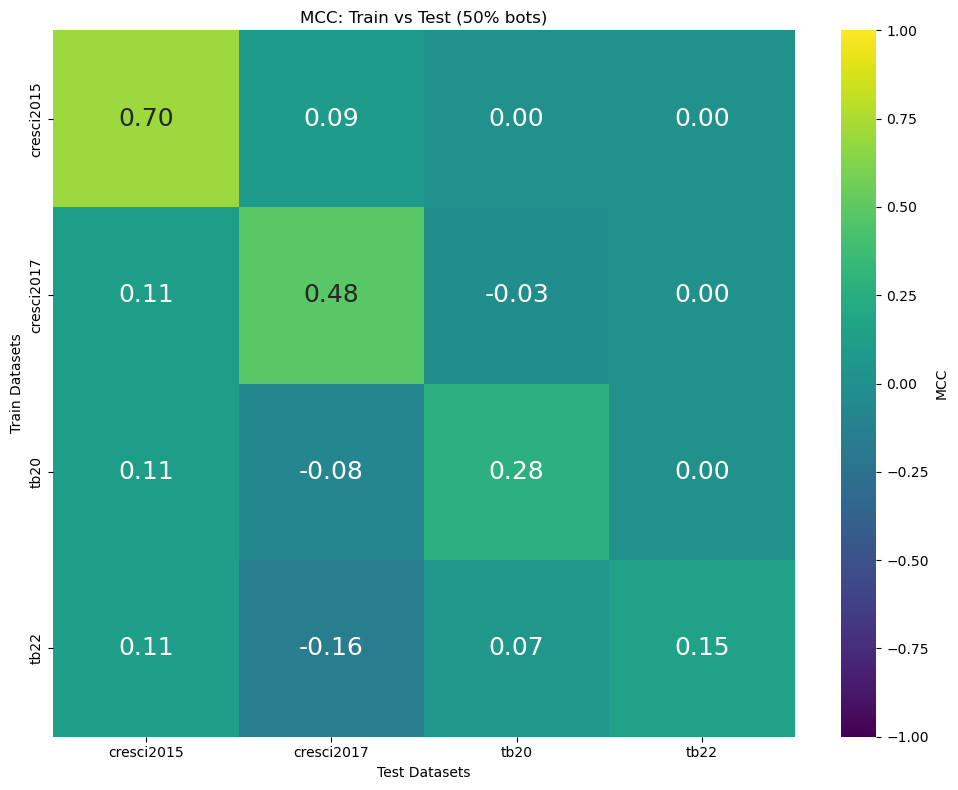

In [18]:
train_test_on_all(1, 'train_test_50', "MCC: Train vs Test (50% bots)", True)

### 20/80

/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


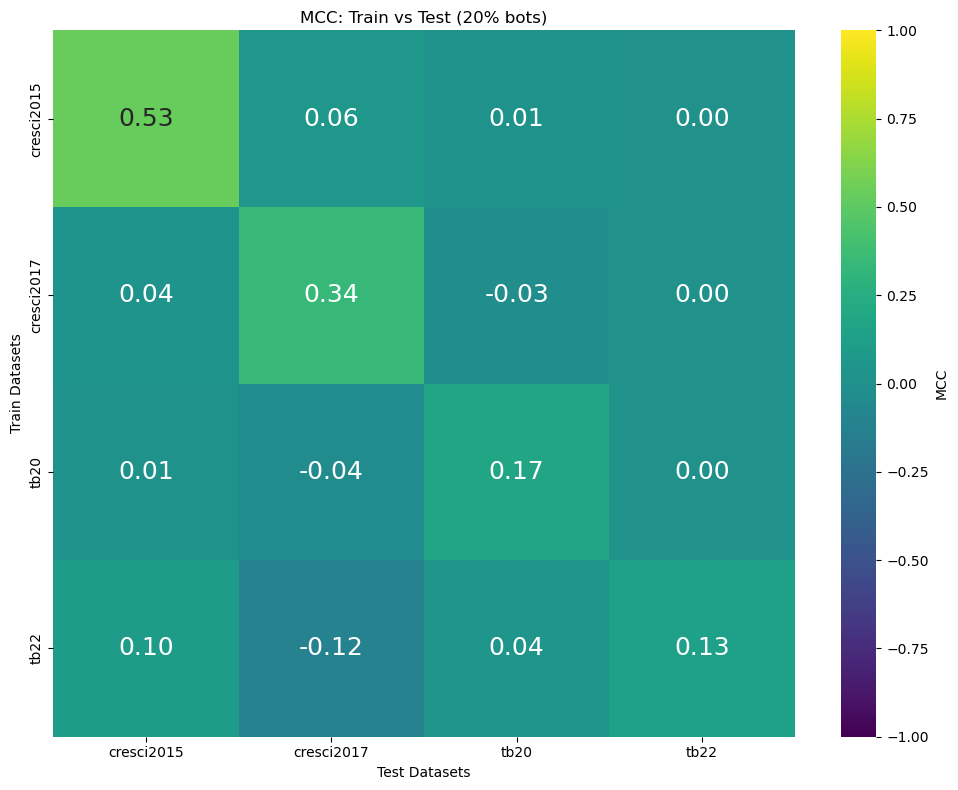

In [19]:
train_test_on_all(1/4, 'train_test_20', "MCC: Train vs Test (20% bots)", True)

### 10/90

/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


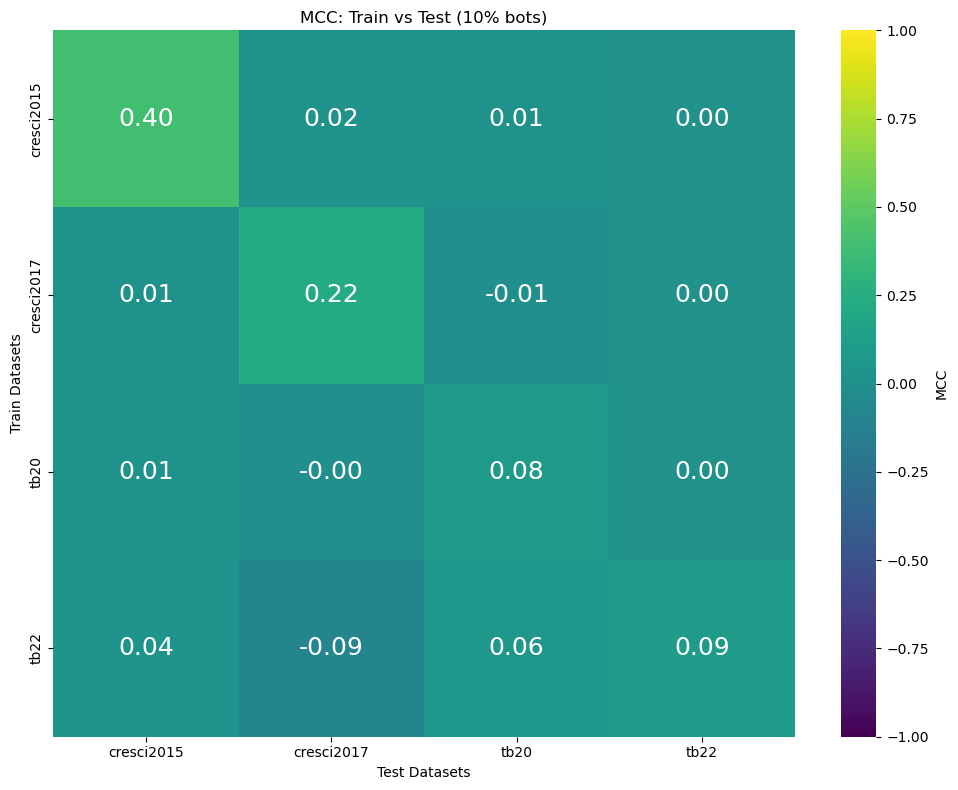

In [21]:
train_test_on_all(1/9, 'train_test_10', "MCC: Train vs Test (10% bots)", True)

### 5/95

/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


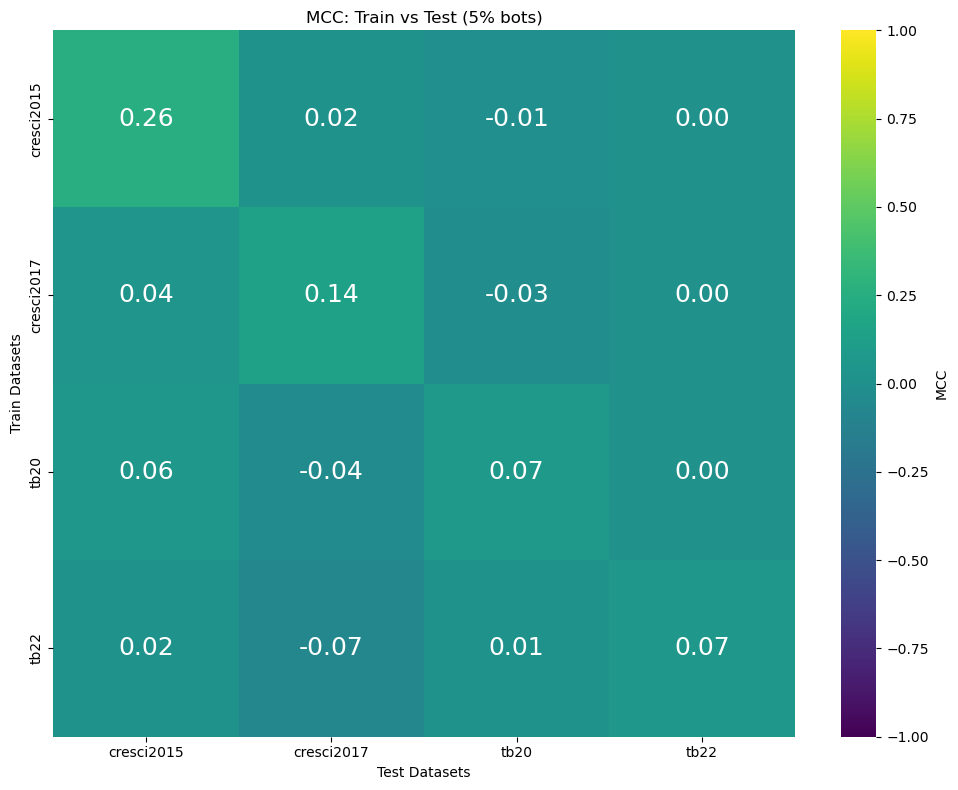

In [22]:
train_test_on_all(1/19, 'train_test_5', "MCC: Train vs Test (5% bots)", True)

### 1/99

/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


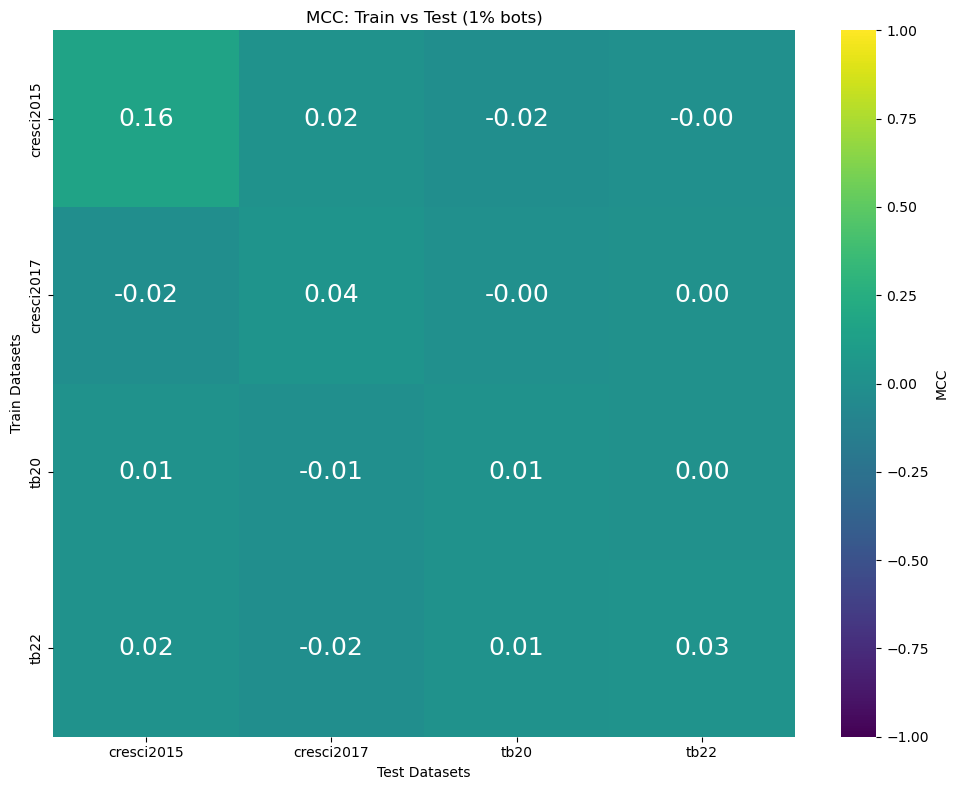

In [23]:
train_test_on_all(1/99, 'train_test_1', "MCC: Train vs Test (1% bots)", False)

### No balancing

/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/petit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


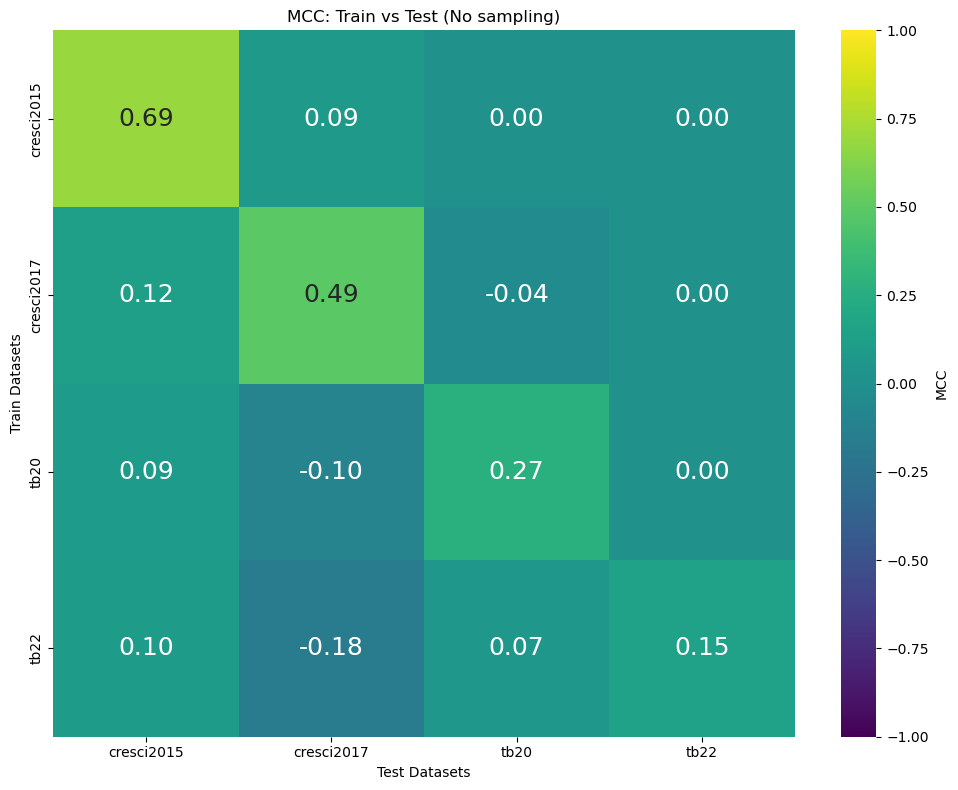

In [24]:
train_test_on_all(1, 'train_test_on_all_nobalancing', "MCC: Train vs Test (No sampling)", False)

In [25]:
print("ok")

ok
